#Chapter 2 - Libraries around Numpy

Numpy is a powerful, yet very basic library, which can be a little abstract to introduce -- and a little tedious to practice. To perform more interesting things to Numpy matrices, we now turn to a number of interesting libraries, which have been built around numpy, or which were designed to interact closely with it.

##Clustering with Scipy

SciPy stands for 'Scientific Python': as its name suggests, this library extends Numpy's raw number crunching capabilities, with interesting scientific functionality, including the calculation of distances between vectors, or common statistical tests. Scipy is commonly imported under the name `sp`:

In [30]:
import scipy as sp

It is time to get practical! In the `data` directory in the repository for this course, I have included a corpus representing novels by three famous British authors from the Victorian era: Jane Austen, Charles Dickens, and William Thackeray. In the next code block, I load these texts and turn them into a vectorized matrix. You can simple execute the code block and ignore it for the time being. In the next chapter, we will deep deeper into the topic of vectorization.

In [2]:
from pystyl.corpus import Corpus
corpus = Corpus(language='en')
corpus.add_directory('data/victorian')
corpus.preprocess()
corpus.tokenize(max_size=50000)
corpus.vectorize(mfi=30, ngram_type='word')

['a',
 'and',
 'as',
 'at',
 'be',
 'but',
 'for',
 'had',
 'have',
 'he',
 'her',
 'him',
 'his',
 'i',
 'in',
 'is',
 'it',
 'mr',
 'my',
 'not',
 'of',
 'on',
 'said',
 'she',
 'that',
 'the',
 'to',
 'was',
 'with',
 'you']

Let us quickly inspect with what kind of data we are working:

In [15]:
X = corpus.vectorizer.X.toarray()
print(X.shape)

(9, 30)


In [16]:
print(corpus)

<Corpus(9 texts)> 
Tokenized texts:
	- Emma	(cat: Austen):	'emma by jane austen volume i chapter i emma woodhouse'[...]
	- Pride	(cat: Austen):	'pride and prejudice by jane austen chapter it is a'[...]
	- Sense	(cat: Austen):	'sense and sensibility by jane austen chapter the family of'[...]
	- Bleak	(cat: Dickens):	'bleak house by charles dickens preface a chancery judge once'[...]
	- David	(cat: Dickens):	'david copperfield by charles dickens affectionately inscribed to the hon'[...]
	- Hard	(cat: Dickens):	'charles dickens hard times book the first sowing chapter i'[...]
	- Barry	(cat: Thackeray):	'barry lyndon from the works of william makepeace thackeray edited'[...]
	- Pendennis	(cat: Thackeray):	'william makepeace thackeray the history of pendennis chapter i shows'[...]
	- Vanity	(cat: Thackeray):	'vanity fair by william makepeace thackeray before the curtain as'[...]


One common methodology in stylometry is clustering: by drawing a tree diagram or 'dendrogram', representing the relationships between the texts in a corpus, we attempt to visualize the main stylistic structure in our data. Texts that cluster together under a similar branch in the resulting diagram, can be argued to be stylistically closer to each other, than texts which occupy completely different places in the tree. Texts by the same authors, for instance, will often form thight clades in the tree, because they are written in a similar style. Below goes an example of the type of tree we will be building in this chapter.

In [11]:
# example of tree

Clustering algorithms are based on the distances between texts: clustering algorithms typically start by calculating the distance between each pair of texts in a corpus, so that know for each text how (dis)similar it is from any other text. Only after these distances have been fully calculated, the clustering algorithm can start building a tree representation, in which the similar texts are joined together and merged into new nodes. To create a distance matrix, scipy offers a convenient function `pdist`, which can be used to calculate the pairwise distances between all the rows in a matrix (i.e. all the texts in a corpus, in our case): 

In [17]:
from scipy.spatial.distance import pdist, squareform

We can now run this function on our corpus. To obtain a nice and clean matrix, we apply `squareform()` to `pdist`'s: result: like that, we obtain a matrix which has a row as well as a column for each of our original texts. This representation is a bit superfluous, because `matrix[i][j]` will be identical to `matrix[j][i]`. This is because distance metric in stylometry are symmetric: the distance of document B to document A is equal to the distance from document A to document B:   

In [19]:
dm = squareform(pdist(X, 'cityblock'))
print(dm.shape)

(9, 9)


As is clear from the shape info, we have obtained a 9 by 9 matrix, which holds the distance between each pair of texts. Note that the distance from a text is zero:

In [20]:
print(dm[3][3])
print(dm[8][8])

0.0
0.0


and that the from text A to text B, is equal to the distance from B to A:

In [21]:
print(dm[2][3])
print(dm[3][2])

1.33189447209
1.33189447209


To be able to visualize a dendrogram, we must first take care of the linkages in the tree: this procedure will start by merging ('linking') the most similar texts in the corpus into a new mode; only at a later stage in the tree, these nodes of very similar texts will be joined together with nodes representing other texts. We perform this - fairly abstract - step on our distance matrix as follows:

In [22]:
from scipy.cluster.hierarchy import linkage
linkage_object = linkage(dm, method='ward', metric='euclidean')

Here, we specify that we wish to use Ward's linkage method, which is one of the most common linkage functions in stylometry. We are now ready to draw the actual dendrogram. To make sure that our plots are properly displayed in the notebook, we must first execute this line:

In [23]:
%matplotlib inline

We can now draw our dendrogram. Note that we annotate the outer leaf nodes in our tree (i.e. the texts) using the `labels` argument. With the `orientation` argument, we make sure that our dendrogram can be easily read:  

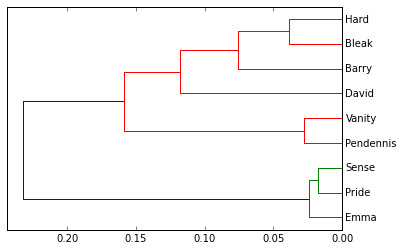

In [25]:
from scipy.cluster.hierarchy import dendrogram
dm = squareform(pdist(X, 'cosine'))
linkage_object = linkage(dm, method='ward')
d = dendrogram(Z=linkage_object, labels=corpus.titles, orientation='right')

As we can see, Jane Austen's novels form a tight and distinctive cloud; apparantly Dickens and Thackeray are more difficult to tell apart. The actual distance between nodes is hinted at on the horizontal length of the branches (i.e. the values on the x-axis in this plot). The previous code blocks used the Manhattan city block distance, a very simple distance metric which is also used in the calculation of Burrows's Delta. Note that we can easily switch to, for instance, the Euclidean distance:

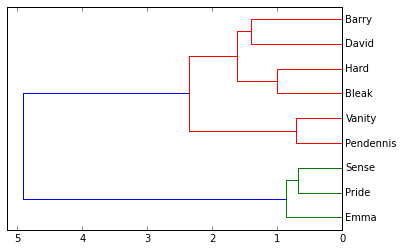

In [27]:
dm = squareform(pdist(X, 'cityblock'))
linkage_object = linkage(dm, method='ward')
d = dendrogram(Z=linkage_object, labels=corpus.titles, orientation='right')

##Burrows's Delta yourself

SciPy is flexible enough to be useful for a variety of analysis. One interesting application which is easy to implement with SciPy is Burrows's Delta, a well-known attribution method in stylometry.

In [28]:
x_test = X[0]
X_train = X[1:]
print(x_test.shape)
print(X_train.shape)

(30,)
(8, 30)


In [33]:
from scipy.spatial.distance import cityblock as manhattan
print(manhattan(x_test, X_train[3]))

1.54813017588


In [37]:
from scipy.spatial.distance import cdist

In [47]:
dists = []
for v in X_train:
    dis
print(dists)

[0.49950633147284818, 0.59089713776344366, 1.3684506049324998, 1.5481301758795694, 1.0753423961342283, 1.5640285897755251, 1.642123619176576, 1.4457630306150553]


Or with a list comprehension:

In [50]:
dists = [manhattan(x_test, v) for v in X_train]

In [48]:
import numpy as np
nearest_neighbour_idx = np.argmin(dists)
print(nearest_neighbour_idx)

0
